<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
x=====
                  open         low        high      volume
date                                                      
2010-01-04  312.304948  310.955001  313.580158   3927000.0
2010-01-05  312.419511  309.610028  312.748278   6031900.0
2010-01-06  311.761979  302.048370  311.761979   7987100.0
2010-01-07  303.562685  295.218951  303.861575  12876600.0
2010-01-08  294.895159  293.455551  300.499172   9483900.0
...                ...         ...         ...         ...
2016-12-23  790.900024  787.280029  792.739990    623400.0
2016-12-27  790.679993  787.656982  797.859985    789100.0
2016

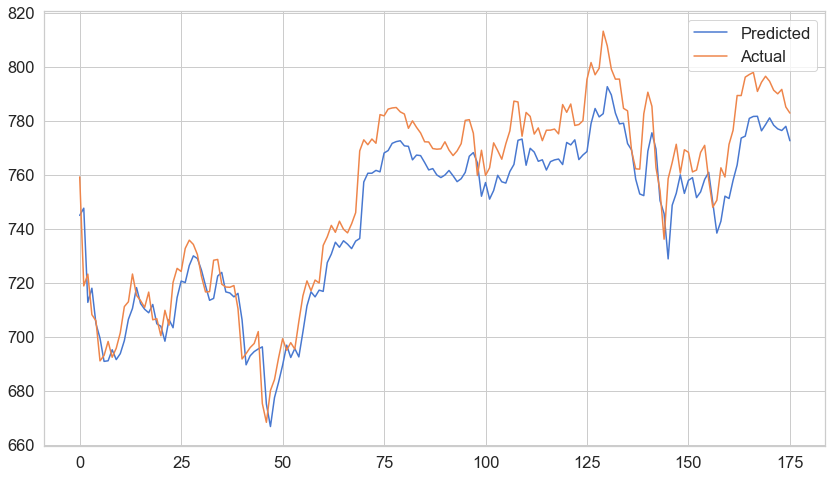

In [2]:
#https://www.kaggle.com/kshitijmohan/lstm-stock-prediction
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from sklearn import metrics
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tabpy_client
import requests
import json
#%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

df = pd.read_csv("../data/prices-split-adjusted.csv")
df.info()


plot_x = df['date'].copy()
df.set_index("date", inplace = True)
df.index = pd.to_datetime(df.index)
df.head()


google_stock = df[df['symbol'] == 'GOOG']
google_stock.head()

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
goog_df = google_stock.copy()
goog_df.drop(['symbol'], axis=1, inplace=True)
x = goog_df[['open', 'low', 'high', 'volume']].copy()

print('x=====')
print(x)

y = goog_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    
    #print('amount_of_features')
    
    #print(amount_of_features)
    
    X_mat = X.values
    
    print(X_mat)
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    #print('data 01')
    #print(data)
    
    data = np.array(data)
    
    
    #print('data 02')
    #print(data)
    
    print('data')
    print(data.shape[0])
    
    train_split = int(round(train_size * data.shape[0]))
    
    print('train_split')
    print(train_split)
    
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 1
x['close'] = y

print('x')
print(x.iloc[[0]]) #get row 0

X_train, y_train, X_test, y_test = load_data(x, window)


print('X_train')
print(X_train[0]) #get row 0


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (X_train[0], y_train[0])


def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(input_shape=(window, 5))

model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)

save_model(model, "../model/model_02.h5")


model.summary()

dump(x_scaler,open('../model/x_scaler.pkl','wb'))
dump(y_scaler,open('../model/y_scaler.pkl','wb'))

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(176, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(176, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

plot_x = pd.to_datetime(plot_x.iloc[-176:])

plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()